In [58]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import networkx as nx
from scipy.linalg import expm
sys.path.insert(0, "../")
import tools_graphs as tg

# Centrality, Communicability and Betweeness

We can have different measures that tell us information about a network. Some example is the centrality measures which tell us how well connected is a single node. A simlpe example is the degree, which counts the number of edges involving a node.
$$deg_i = \sum_i^N a_{ik} = (Ae)i$$

However, this measure does not take in account anything but the inmediate surroundings of the node. Katz in 1953 elavorated a more shophisticated measure

$$k_i := \sum_{j=1}^N \sum_{k=0}^\infty \alpha^k (A)_{ij}^k$$

which also measures the further nodes impact but giving more weight to the closer ones. To see why this is true we have to understand what does it means the matrix exponential of an Adjacency matrix. Assuming that every node is reachable(full connected graph). We define the _path length_ n between two nodes i and j as a list of ordered nodes i,k_1,k_2,...,k_{n-1},j which are consecutively connected, i.e:
$$a_{i,k_1}=a_{k_1,k_2}=...=a_{k_{n-2},k_{n-1}}=a_{k{n-1},j}=1$$

In other words is the number of nodes needed to cross in order to get from i to j. Hence, the adjacnecy matrix indicate the pathlengths 1 if $a_{ij}=1$ or higher if $a_{ij}=0$. However, what happen with $A^2$? Knowing that its entries are $(A^2)_{ij} = \sum_{k=1}^N a_{ik}a{kj}$ we can interpret as following: for each connected node to i check if there is connection with j. this is basically the sum of pathlenght 2 btween i and j. Readily, we can see how (A^2)_{ii} is equivalent to the $deg_i$ as it counts the number of walks that start and end in the same node. Is always possible to visit the adjacent nodes and come back trought the same connection. This result can be genralized to higher order exponents

$$(A^n)_{ij} = \sum_{k_1=1}^N \sum_{k_1=1}^N \sum_{k_{n-2}=1}^N  \sum_{k_{n-1}=1}^N a_{i,k_1}a_{k_1,k_2}...a_{k_{n-2},k_{n-1}}a_{k_{n-1},j}$$

which measures the number of walks of length n that connect the nodes. This lead to the following lemma

**Lemma 1.1.** The quantity $(An)_{ij}$ counts the number of different walks $(i\neq j)$ or closed walks $(i = j)$ of length n between nodes i and j.

Now we are ready to introduce the topics of centrality, communicability and betweeness trought matrices exponential as defined by Estrada.

### Centrality

As stated above, centrality is the node measure of _well-connectedness_. The degree is equivalent to the digonal of the squared adjacency matrix $A^2$, which is the sum of all the closed loop walks of legnth 2. However, the closed loop walks of length 3 are an indicator of well connected neighbours. And the same can be extended for longer closed loop walks. Adding this information result in a richer measure of connectedness. However, it seems natural to weight more the shorter paths where the information is more likely to travel. Particularly, if we choose a weight decay of $\frac{1}{n!}$ it results in

$$\Big(\frac{A^2}{2!}+ \frac{A^3}{3!} + ... + \frac{A^k}{k!} + ...\Big)_{ii}$$

since the relative measure does not change if we add a constant and recalling that $a_{ii}=0$, it might change to  

$$\Big(I + A + \frac{A^3}{3!} + ... + \frac{A^k}{k!} + ...\Big)_{ii}$$

This is exactly equivalent to $(exp(A))_{ii}$ so we can define the centrality as the diagonal of the adjacency exponential.

### Communicability

The communicability is a measure of how well connected two nodes are. For example we can think of a network of cities where the edges are the roads. The more roads start in a city A and ends in city B, the better are communicated. Of course, direct roads are more important that long ones. Naturally, $(exp(A))_{ij}$ can be used to measure communicabilty. In fact this is the definition of Estrada in [ref]

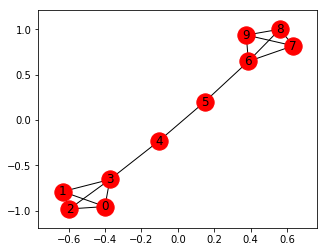

In [151]:
G = nx.barbell_graph(4,2)
A = nx.to_scipy_sparse_matrix(G,dtype=np.float64)
nx.draw_networkx(G)
plt.show()

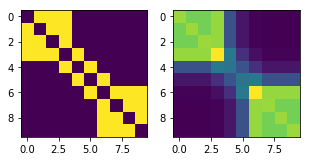

In [152]:
fig, axarr = plt.subplots(1,2)
axarr[0].imshow(A.todense())
axarr[1].imshow(expm(A.todense()))
plt.show()

As we can see the communicability within the groups are generally higher. Also it is important to note how the nodes closer to the "bridge" have higher communicability as there are better connected to the opposite group. Let's check a Stochastic Block Model(SBM) when it scales.

In [180]:
N = 100
G,labels = tg.sample_SBM(N,0.4,0.1)
A = nx.to_scipy_sparse_matrix(G,dtype=np.float64)

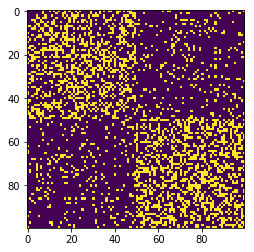

In [181]:
plt.imshow(A.todense())
plt.show()

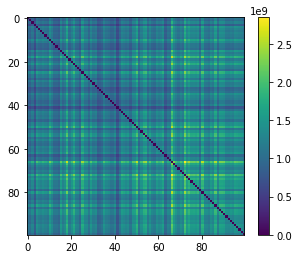

In [182]:
C_nonscaled = expm(A.todense())
C_nonscaled = C_nonscaled - np.diag(np.diag(C_nonscaled))
plt.imshow(C_nonscaled)
plt.colorbar()
plt.show()

As expected within groups are better communicated. However, note how the values have grown rapidly due the mapping $\lambda_i \mapsto e^{\lambda_i}$ where $\lambda_i$ is the i-th eigenvalue of A. This can be solved by dividing A by its maxiumum eigenvalue prior to calculate the exponential.
$$\frac{1}{\lambda}A = \frac{1}{\lambda}Q \Lambda Q^T = Q\frac{1}{\lambda}\Lambda Q^T$$
where $\lambda$ is the maxiumum eigenvalue of A.

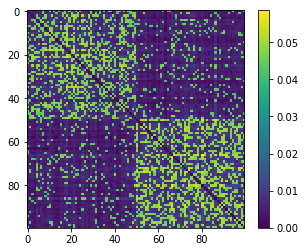

In [183]:
eig,vec = np.linalg.eig(A.todense())
C_scaled = expm(A.todense()/max(eig))
eigC,vec1 = np.linalg.eig(C_scaled)
C_scaled = C_scaled - np.diag(np.diag(C_scaled))
plt.imshow(C_scaled)
plt.colorbar()
plt.show()

This leads to a better differentation of the groups. As previous values with small connections are not mapped into high values. 

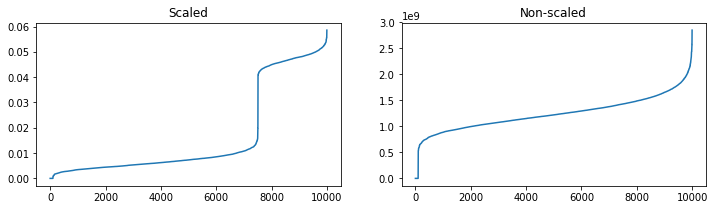

In [184]:
values_scaled = np.sort(np.reshape(C_scaled,(N*N)))
values_nonscaled = np.sort(np.reshape(C_nonscaled,(N*N)))
fig,axarr = plt.subplots(1,2,figsize=(12,3))
axarr[0].plot(values_scaled)
axarr[0].set_title('Scaled')
axarr[1].plot(values_nonscaled)
axarr[1].set_title('Non-scaled')
plt.show()

## TO DO:
- understand eigenbasis
- Generic commnuicability. write down generic Mclurin series and spectrum
- Specific case of resolvent downweighting. Motivation
- Write down formulas

## Resolvent 

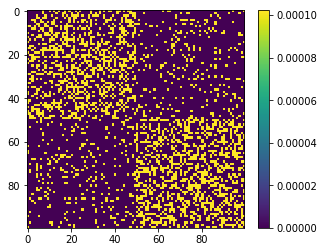

In [247]:
alpha = (1/float(N-1))
R = np.linalg.inv(np.eye(N)-alpha*alpha*A) 
R = R - np.diag(np.diag(R))
plt.imshow(R)
plt.colorbar()
plt.show()

In [245]:
eigR,V = np.linalg.eig(R)